In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
#Build the Model
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1)
        
        self.fc1 = nn.Linear(in_features= 5*5*16, out_features= 120)
        self.fc2 = nn.Linear(in_features= 120, out_features= 84)
        self.fc3 = nn.Linear(in_features= 84, out_features= 10)
        
    def forward(self, x):
        x = f.relu(self.conv1(x)) 
        x = f.max_pool2d(x,2,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,2,2)
        
        # Re-View to flatten it out for input to fully-connected-layer
        x = x.view(-1, 16*5*5) #negative 1 so that we can vary the batch size, The -1 for the first dimension is a placeholder that tells PyTorch to calculate the correct number based on the original size of x and the size of the second dimension.
        
        # Fully Connected layers
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x) #final output layer
        return f.log_softmax(x, dim = 1)

In [164]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = './cnn_data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = './cnn_data', train = False, download = True, transform = transform)

In [165]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [166]:
torch.manual_seed(41)
model = CNN_Model()
model

CNN_Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [167]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001) #smaller the learning rate, longer it takes to train.

In [168]:
import time
start_time = time.time()


#variables to track
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    #Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1] # add up number of correct predictions.
        trn_corr += (predicted == y_train).sum() #correct in a batch
        
        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(b%600 == 0):
            print(f"Epoch: {i}, Batch: {b}, Training Loss = {loss.item()}")
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #Test
    with torch.no_grad(): #so that we dont update our weights and biases with test data.
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # add up number of correct predictions.
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

curr_time = time.time()
total = curr_time - start_time
print(f'total time {total/60} minutes!')

Epoch: 0, Batch: 600, Training Loss = 0.16000792384147644
Epoch: 0, Batch: 1200, Training Loss = 0.16006726026535034
Epoch: 0, Batch: 1800, Training Loss = 0.4769926965236664
Epoch: 0, Batch: 2400, Training Loss = 0.15090204775333405
Epoch: 0, Batch: 3000, Training Loss = 0.007131108082830906
Epoch: 0, Batch: 3600, Training Loss = 0.262676477432251
Epoch: 0, Batch: 4200, Training Loss = 0.004135420545935631
Epoch: 0, Batch: 4800, Training Loss = 0.0016134731704369187
Epoch: 0, Batch: 5400, Training Loss = 0.050943147391080856
Epoch: 0, Batch: 6000, Training Loss = 0.0005367685807868838
Epoch: 1, Batch: 600, Training Loss = 0.00249813636764884
Epoch: 1, Batch: 1200, Training Loss = 0.21273458003997803
Epoch: 1, Batch: 1800, Training Loss = 0.0036792834289371967
Epoch: 1, Batch: 2400, Training Loss = 0.0055530681274831295
Epoch: 1, Batch: 3000, Training Loss = 0.03134659305214882
Epoch: 1, Batch: 3600, Training Loss = 0.38388580083847046
Epoch: 1, Batch: 4200, Training Loss = 0.023995270

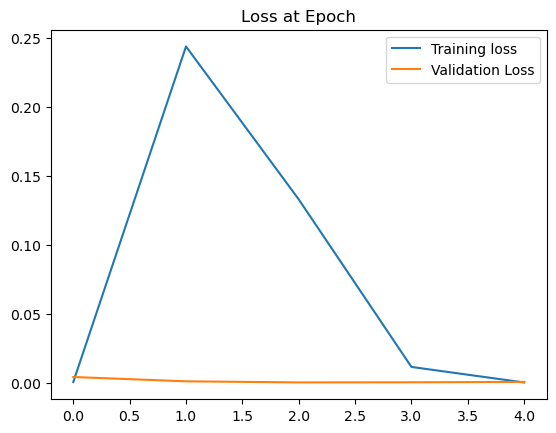

In [169]:
#Graph the loss at epoch
new_train_losses = [tl.item() for tl in train_losses]
plt.plot(new_train_losses, label= "Training loss")
plt.plot(test_losses, label = 'Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

[tensor(56229), tensor(58804), tensor(59149), tensor(59289), tensor(59507)] [tensor(9753), tensor(9831), tensor(9852), tensor(9866), tensor(9864)]


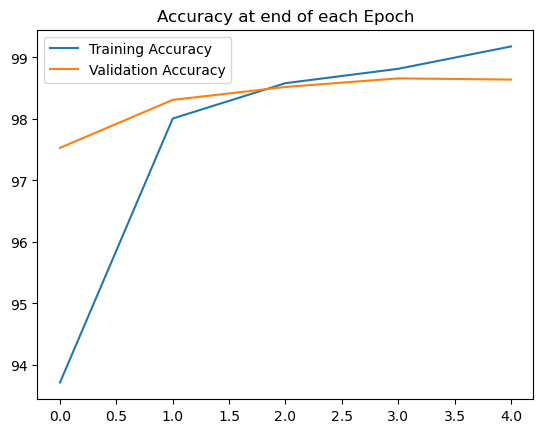

In [177]:
#Graph the accuracy at each epoch
print(train_correct, test_correct)
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title('Accuracy at end of each Epoch')
plt.legend()

In [178]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [179]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1] # add up number of correct predictions.
        correct += (predicted == y_test).sum()

In [180]:
# Correct
correct.item()/ len(test_data) *100

98.64